In [1]:
import numpy as np
import pandas as pd
import torch

from netam import framework
from netam.framework import load_crepe
from netam.models import RSSHMoofModel


# URLs for the TSV files
kmer_url = 'https://raw.githubusercontent.com/statbiophys/shmoof/master/mutabilities_context.tsv'
site_url = 'https://raw.githubusercontent.com/statbiophys/shmoof/master/mutabilities_position.tsv'

# Reading the TSV files
kmer_df = pd.read_csv(kmer_url, sep='\t').sort_values(by='Motif').reset_index(drop=True)
site_df = pd.read_csv(site_url, sep='\t').sort_values(by='Position').reset_index(drop=True)

kmer_df

,Motif,Mutability,To A,To C,To G,To T
0,AAAAA,0.968592,0.000000,0.148277,0.715525,0.136197
1,AAAAC,1.018907,0.000000,0.212120,0.631777,0.156103
2,AAAAG,1.045683,0.000000,0.231142,0.653723,0.115135
3,AAAAT,1.348683,0.000000,0.110942,0.762132,0.126925
4,AAACA,1.522459,0.000000,0.267000,0.550933,0.182067
...,...,...,...,...,...,...
1019,TTTGT,0.744792,0.479699,0.400815,0.119486,0.000000
1020,TTTTA,1.486867,0.391954,0.474415,0.133631,0.000000
1021,TTTTC,1.050789,0.399552,0.468232,0.132216,0.000000
1022,TTTTG,0.675904,0.366509,0.532731,0.100760,0.000000


Their inferences have some zeros. These are due to the sequencing region. Let's set them to the mean.

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_52402/1553439231.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '234.89693593314763' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  site_df[site_df["Mutability"] == 0.] = site_df[site_df["Mutability"] != 0.].mean()


<Axes: >

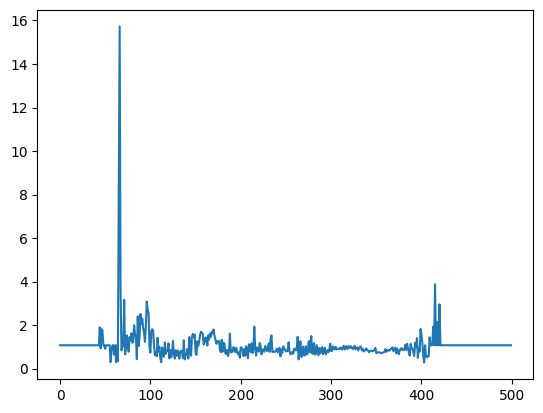

In [2]:
site_df[site_df["Mutability"] == 0.] = site_df[site_df["Mutability"] != 0.].mean()
site_df["Mutability"].plot()

In [3]:
kmer_to_load_df = kmer_df[['Motif']].copy()
for base in 'ACGT':
    kmer_to_load_df[base] = kmer_df["Mutability"] * kmer_df[f"To {base}"]
kmer_to_load_df.set_index('Motif', inplace=True)

mean_row = kmer_to_load_df.mean(axis=0)
mean_row_df = pd.DataFrame(mean_row).T
mean_row_df.index = ['N']

kmer_to_load_df = pd.concat([mean_row_df, kmer_to_load_df], axis=0)

kmer_to_load_df

,A,C,G,T
N,0.249969,0.303739,0.301567,0.253111
AAAAA,0.000000,0.143620,0.693052,0.131920
AAAAC,0.000000,0.216131,0.643722,0.159055
AAAAG,0.000000,0.241701,0.683587,0.120395
AAAAT,0.000000,0.149626,1.027875,0.171182
...,...,...,...,...
TTTGT,0.357276,0.298524,0.088992,0.000000
TTTTA,0.582783,0.705393,0.198691,0.000000
TTTTC,0.419845,0.492013,0.138931,0.000000
TTTTG,0.247725,0.360075,0.068104,0.000000


In [4]:
shmoof = RSSHMoofModel(5, 500)

shmoof.kmer_embedding.weight.data = torch.log(
    torch.tensor(kmer_to_load_df.values, dtype=torch.float32))
shmoof.log_site_rates.weight.data = torch.log(torch.tensor(site_df["Mutability"].values)).unsqueeze(-1)

In [5]:
out_crepe = framework.Crepe(framework.KmerSequenceEncoder(5, 500), shmoof)

out_crepe.save("../train/trained_models/origshmoof-shmoof_small")